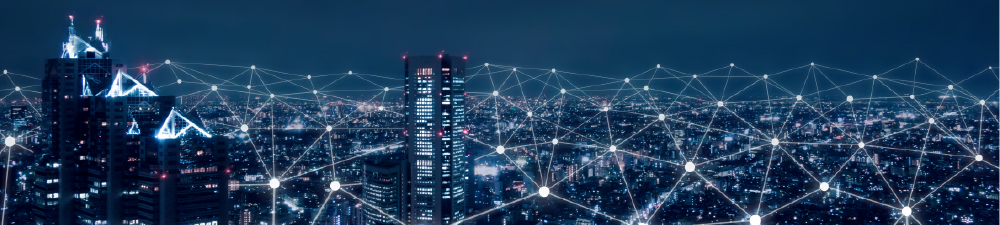

# Teleco Churn Project

A Telecom company is facing high churn rate amongst customers, leading to a revenue decline of ~USD 500k every month. 

This notebook hopes to reduce monthly customer churn by identifying high risk customers well in advance. 

Analytic objective:
1. Build a Classification Model to predict churners one month in advance
2. Identify key churn drivers. 

## Packages and setup

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os

from scipy.stats import shapiro
import scipy.stats as stats

#parameter settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

## Reading data and initial processing

In [2]:
#edit the file location of raw data set
cust_df=pd.read_csv("data.csv")

In [3]:
# Type your code here to explore and understand the data better

#e.g., identify the dimension of cust_df
cust_df.shape

(51047, 58)

<b> <font color = navy> About the Dataset: </b><br>
There are 51047 Rows and 58 Columns 

In [4]:
cust_df.head()

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,...,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,...,0,9,No,1,10,No,1-Highest,Other,Professional,Yes


In [5]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51047 entries, 0 to 51046
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerID                 51047 non-null  int64  
 1   Churn                      51047 non-null  object 
 2   MonthlyRevenue             50891 non-null  float64
 3   MonthlyMinutes             50891 non-null  float64
 4   TotalRecurringCharge       50891 non-null  float64
 5   DirectorAssistedCalls      50891 non-null  float64
 6   OverageMinutes             50891 non-null  float64
 7   RoamingCalls               50891 non-null  float64
 8   PercChangeMinutes          50680 non-null  float64
 9   PercChangeRevenues         50680 non-null  float64
 10  DroppedCalls               51047 non-null  float64
 11  BlockedCalls               51047 non-null  float64
 12  UnansweredCalls            51047 non-null  float64
 13  CustomerCareCalls          51047 non-null  flo

In [6]:
#Check Dataset Churns
cust_df["Churn"].value_counts()

No     36336
Yes    14711
Name: Churn, dtype: int64

In [7]:
#Check Dataset Churns
cust_df["Churn"].value_counts()/cust_df.shape[0]

No     0.711815
Yes    0.288185
Name: Churn, dtype: float64

## Part 1. Detect and resolve problems in the data (Missing value, Outliers, Unexpected value, etc.)

### 1.1 How many customers had zero monthly revenue?

In [8]:
#How many customers had zero monthly revenue?

cust_zero_monthly_rev_df = cust_df[cust_df["MonthlyRevenue"] == 0]
print('Number of customers with zero monthly revenue =',cust_zero_monthly_rev_df.shape[0])

Number of customers with zero monthly revenue = 6


In [9]:
#Exclude the customers with zero monthly revenue from cust_df and from any subsequent analysis

cust_df.drop(cust_zero_monthly_rev_df.index, inplace=True)
cust_df.reset_index(drop=True, inplace=True)
cust_df

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,...,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,...,0,9,No,1,10,No,1-Highest,Other,Professional,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51036,3399958,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,6,No,0,60,No,1-Highest,Suburban,Other,Yes
51037,3399974,No,95.17,1745.0,85.0,0.99,45.0,4.7,122.0,15.9,...,0,9,No,1,60,No,3-Good,Other,Other,No
51038,3399978,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,7,No,1,80,No,5-Low,Other,Clerical,No
51039,3399990,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,9,No,0,30,No,5-Low,Other,Other,No


### 1.2 How many columns has missing values percentage > 5%

In [10]:
#Calculate for each column % of missing value in the data

percent_missing = cust_df.isnull().sum() * 100 / len(cust_df)
missing_value_df = pd.DataFrame({'column_name': cust_df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True, ascending=False)
missing_value_df.head(15)


,column_name,percent_missing
AgeHH2,AgeHH2,1.780921
AgeHH1,AgeHH1,1.780921
PercChangeMinutes,PercChangeMinutes,0.715111
PercChangeRevenues,PercChangeRevenues,0.715111
MonthlyRevenue,MonthlyRevenue,0.305637
MonthlyMinutes,MonthlyMinutes,0.305637
TotalRecurringCharge,TotalRecurringCharge,0.305637
DirectorAssistedCalls,DirectorAssistedCalls,0.305637
OverageMinutes,OverageMinutes,0.305637
RoamingCalls,RoamingCalls,0.305637


<font color = navy> Based on above information, there are at most 1.780921% of data missing from any one column i.e. none have more than 5% missing 

In [11]:
#How many columns has missing values percentage > 5%

print('Number of columns with more than 5% missing values = ',missing_value_df.loc[missing_value_df['percent_missing'] >= 5.0].shape[0])


Number of columns with more than 5% missing values =  0


In [12]:
#What strategy should be used for imputation?
# Since no column has missing value % greater than 5%, we can drop all the missing value columns
cust_df.dropna(inplace=True)
cust_df.reset_index(drop=True, inplace=True)

#uncomment below to check that none of the columns have null values
#cust_df.isnull().sum() 

#check number of rows left
cust_df.shape


(49748, 58)

### <font color = navy> Since the percentage of missing number is small, we can drop rows with missing data 

### 1.3 For columns, "UniqueSubs" and "DirectorAssistedCalls" remove outliers, if any

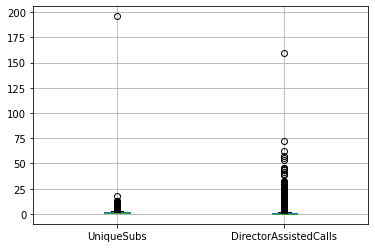

In [13]:
#plot box plot using pandas for columns "UniqueSubs" and "DirectorAssistedCalls"
cols=["UniqueSubs","DirectorAssistedCalls"]
_ = cust_df.boxplot(column=cols)

Number of outliers in UniqueSubs = 215
Number of outliers in DirectorAssistedCalls = 467


,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,...,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,...,0,9,No,1,10,No,1-Highest,Other,Professional,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49743,3399882,Yes,38.34,320.0,30.0,0.99,21.0,0.0,-66.0,-8.3,...,0,6,No,0,Unknown,No,1-Highest,Other,Professional,No
49744,3399906,No,31.92,63.0,17.0,0.00,43.0,0.0,-38.0,-13.2,...,0,3,No,0,Unknown,No,3-Good,Other,Other,Yes
49745,3399942,No,71.99,724.0,70.0,0.00,4.0,0.9,-40.0,-2.0,...,0,7,No,0,Unknown,No,1-Highest,Other,Professional,Unknown
49746,3399946,Yes,117.49,384.0,30.0,0.00,250.0,0.0,0.0,0.0,...,0,2,No,0,30,No,5-Low,Other,Professional,Yes


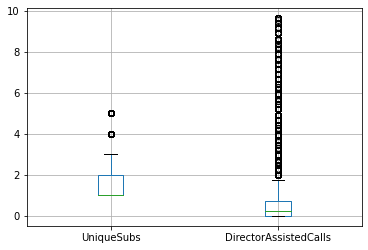

In [14]:
#Use "quantile" function to identify top 1% outliers
us_outlier = cust_df["UniqueSubs"].quantile(0.99)
da_outlier = cust_df["DirectorAssistedCalls"].quantile(0.99)

#Remove top 1% outliers from the above mentioned two columns
cust_us_outlier_df = cust_df[cust_df["UniqueSubs"] > us_outlier]
print('Number of outliers in UniqueSubs =',cust_us_outlier_df.shape[0])
cust_df.drop(cust_us_outlier_df.index, inplace=True)

cust_da_outlier_df = cust_df[cust_df["DirectorAssistedCalls"] > da_outlier]
print('Number of outliers in DirectorAssistedCalls =',cust_da_outlier_df.shape[0])
cust_df.drop(cust_da_outlier_df.index, inplace=True)
cust_df

#plot the box plot again for columns "UniqueSubs" and "DirectorAssistedCalls"
cols=["UniqueSubs","DirectorAssistedCalls"]
_ = cust_df.boxplot(column=cols)

## Part 2. Perform exploratory analysis to analyze customer churn

### 2.1 Does customers with high overage minutes also have high revenue?

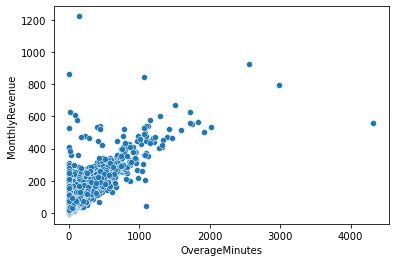

In [15]:
#use scatter plot to find the correlation between monthly revenue and overage minutes
_ = sns.scatterplot(x = 'OverageMinutes', y = 'MonthlyRevenue', data = cust_df )

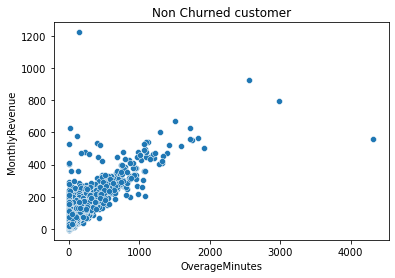

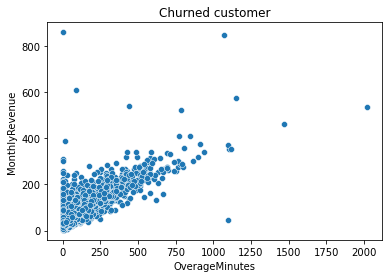

In [16]:
_= plt.title("Non Churned customer")
_= sns.scatterplot(x = 'OverageMinutes', y = 'MonthlyRevenue', data = cust_df[cust_df.Churn=="No"])
plt.show()

_= plt.title("Churned customer")
_= sns.scatterplot(x = 'OverageMinutes', y = 'MonthlyRevenue', data = cust_df[cust_df.Churn=="Yes"])
plt.show()

### <font color = navy> In general, there seems to be a positive correlation between monthly revenue and overage minutes. However, this effect seems consistent between churn and non-churners (with no observable difference in the scatter plots). 

### 2.2 Does high number of active subscribers lead to low monthly revenue?

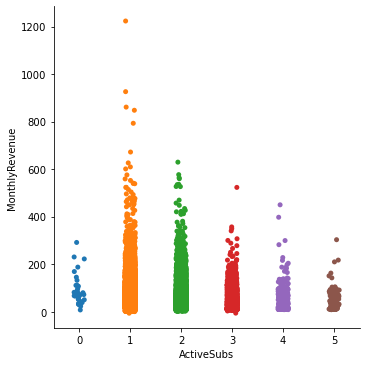

In [17]:
#use category plot to plot monthly revenue for each active subs category
_ = sns.catplot(x='ActiveSubs', y='MonthlyRevenue', data=cust_df) 

### <font color = navy> Higher number of active suscribers lead to lower monthly revenue

### 2.3 Does credit rating have an impact in churn rate?

In [18]:
pd.crosstab(cust_df.Churn, cust_df.CreditRating).apply(lambda r: r/r.sum(), axis=0)
pd.crosstab(cust_df.Churn, cust_df.CreditRating).apply(lambda r: r/r.sum(), axis=1)

CreditRating,1-Highest,2-High,3-Good,4-Medium,5-Low,6-VeryLow,7-Lowest
Churn,,,,,,,
No,0.693462,0.700059,0.692327,0.74253,0.782293,0.735915,0.712949
Yes,0.306538,0.299941,0.307673,0.25747,0.217707,0.264085,0.287051


CreditRating,1-Highest,2-High,3-Good,4-Medium,5-Low,6-VeryLow,7-Lowest
Churn,,,,,,,
No,0.162345,0.370581,0.160003,0.109287,0.138529,0.017905,0.041350
Yes,0.178887,0.395786,0.177249,0.094462,0.096099,0.016017,0.041501


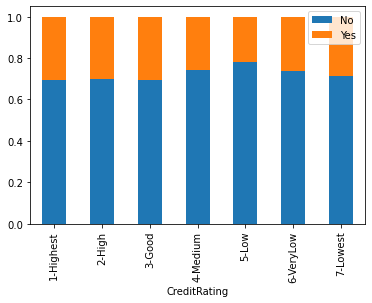

In [19]:
df_no = cust_df.groupby('CreditRating')['Churn'].apply(lambda x: x[x.str.contains('No')].count()/x.count())
df_yes = cust_df.groupby('CreditRating')['Churn'].apply(lambda x: x[x.str.contains('Yes')].count()/x.count())
df_CreditRating = pd.concat([df_no, df_yes], axis = 1)
df_CreditRating.columns = ["No", "Yes"]
ax = df_CreditRating.plot(kind = 'bar', mark_right = True, stacked = True)


### <font color = navy> It seems people irrespective of their credit rating customers are churning and the proportion of churned custmer is larger on high credit score. 

## Part 3. Create additional features to help predict churn

In [20]:
#wrapper function to create additional features for churn prediction
def create_features(cust_df):
    
    #3.1 Percent of current active subs over total subs
    cust_df['perc_active_subs'] = cust_df['ActiveSubs'] / cust_df['UniqueSubs']
    
    #3.2 Percent of recurrent charge to monthly charge
    #type your code here to create a new column in cust_df
    cust_df['perc_recurrent_charge'] = cust_df['TotalRecurringCharge'] / cust_df['MonthlyRevenue']
    
    #3.3 Percent of overage minutes over total monthly minutes
    #type your code here to create a new column in cust_df
    cust_df['perc_overage_minutes'] = cust_df['OverageMinutes'] / cust_df['MonthlyMinutes']    
    
    #type your code here to create any other additional features which you think will help improve your model accuracy
      
    return cust_df  


In [21]:
#Make a call to the feature engineering wrapper function for churn prediction
cust_df=create_features(cust_df)

In [22]:
#Calculate for each column % of missing value in the data

percent_missing = cust_df.isnull().sum() * 100 / len(cust_df)
missing_value_df = pd.DataFrame({'column_name': cust_df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True, ascending=False)
missing_value_df.head(15)

,column_name,percent_missing
perc_overage_minutes,perc_overage_minutes,1.359393
AgeHH2,AgeHH2,0.000000
HandsetRefurbished,HandsetRefurbished,0.000000
HandsetWebCapable,HandsetWebCapable,0.000000
TruckOwner,TruckOwner,0.000000
RVOwner,RVOwner,0.000000
Homeownership,Homeownership,0.000000
BuysViaMailOrder,BuysViaMailOrder,0.000000
RespondsToMailOffers,RespondsToMailOffers,0.000000
OptOutMailings,OptOutMailings,0.000000


In [23]:
#check number of rows left
cust_df.shape

(49066, 61)

In [24]:
# drop the rows with null values for the engineered columns since they are less than 5% of data
cust_df.dropna(inplace=True)
cust_df.reset_index(drop=True, inplace=True)

# check if there are any more missing values
cust_df.isnull().sum()

CustomerID               0
Churn                    0
MonthlyRevenue           0
MonthlyMinutes           0
TotalRecurringCharge     0
                        ..
Occupation               0
MaritalStatus            0
perc_active_subs         0
perc_recurrent_charge    0
perc_overage_minutes     0
Length: 61, dtype: int64

In [25]:
#check number of rows left
cust_df.shape

(48399, 61)

In [26]:
cust_df['perc_active_subs'].mean()
cust_df['perc_recurrent_charge'].mean()
cust_df['perc_overage_minutes'].mean()

0.9389126497103907

0.9046519607004259

0.06163374729108712

### <font color = navy> Findings
    
i. Percent of current active subs over total subs refers to the retention rate. The higher the retention rate, the lower the churn. Result is 93.89%, which indicates low churn.

ii. Percent of recurrent charge to monthly charge refers to proportion of recurrent fees a customer has to pay. The higher the ratio, the lower the churn (since user is locked in to a recurring service as opposed to a one-off service). Result is 90.47%, which indicates low churn.

iii. Percent of overage minutes over total monthly minutes refer to the proportion of call time that exceed a customer's plan. Result is 6.16%, which indicates that there are not many customers who have incur extra minutes above their postpaid allocation.

In [27]:
#Check again churn Count
cust_df['Churn'].value_counts()

No     34752
Yes    13647
Name: Churn, dtype: int64

## Part 4. Build classification model to predict customer churn month in advance

### Initial data processing for model building exercise - We are leaving data as imbalanced for now

### <font color = salmon> Brief discussion about evaluators:
- AUC 
- Precision/Recall
- Confusion Matrix
- Classification Report 

FYI - Decision Trees tend to make more False Negative (Type 2 Errors)       

In [28]:
#Train - test split to train and test model accuracy
from sklearn.model_selection import train_test_split

#Define columns to be included in X and y
X = cust_df.drop(['CustomerID','Churn'], axis=1)
y = cust_df['Churn']

#Create dummy variables for all categorical variables
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#Feature scaling for all continuous variables
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

### 4.1 Build a simple logistic regression model to predict churn and evaluate model accuracy on test data set


In [29]:
#-------------------------------- Model training -------------------------------#
from sklearn.linear_model import LogisticRegression
#type your code to build logistic regression model on training data set
LogReg = LogisticRegression(solver='liblinear')
LogReg.fit(X_train_sc, y_train)

LogisticRegression(solver='liblinear')

In [30]:
#-------------------------------- Model testing ---------------------------------#

#type your code here to predict for X_test data set using the fitted model
preds = LogReg.predict(X_test_sc)

#Use a probability threshold to classify customers as churners and non churners (Default = 0.5)
score = LogReg.score(X_test_sc, y_test)

### <font color = salmon> Brief discussion ahout optimal Threshold for ROC Curve:

The Geometric Mean or G-Mean is a metric for imbalanced classification that, if optimized, will seek a balance between the sensitivity and the specificity.

G-Mean = sqrt(Sensitivity * Specificity)
One approach would be to test the model with each threshold returned from the call roc_auc_score() and select the threshold with the largest G-Mean value.    

Best Threshold=-0.956406, G-Mean=0.581


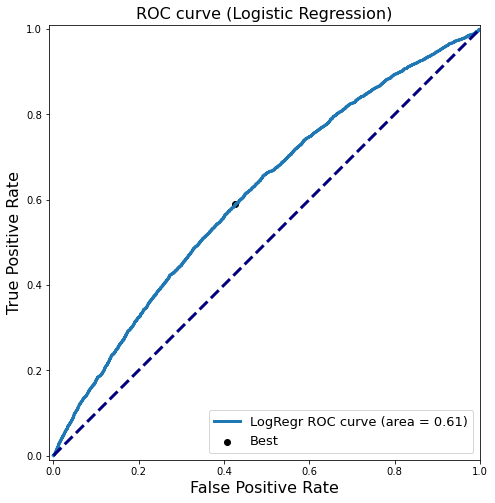

Gini Score is: 0.21842706218712138


In [31]:
#-------------------------------- Model Evaluation ---------------------------------#
#Evaluate model accuracy using fitted y value and actual y_test
#Evaluation metrics to be used - GINI, Precision, Recall, confusion matrix


#-------------------------------- AUC ---------------------------------#
from sklearn.metrics import roc_curve, auc
#Change y_test to 1 and 0
y_test_1 = y_test.replace([ "Yes",  "No"],  [1,0])

#GET AUC
y_score_lr = LogReg.decision_function(X_test_sc)
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_test_1, y_score_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)


#-------------------------------- Get the best threshold ---------------------------------#
#calculate the g-mean for each threshold
from numpy import sqrt
from numpy import argmax
gmeans = sqrt(tpr_lr*(1-fpr_lr))

#locate the index of the largest g-mean
ix = argmax(gmeans)
print("Best Threshold=%f, G-Mean=%.3f" % (threshold_lr[ix],gmeans[ix]))

#-------------------------------- Plot AUC ---------------------------------#

fig = plt.figure(figsize=(8,8))
fig = plt.xlim([-0.01, 1.00])
fig = plt.ylim([-0.01, 1.01])
fig = plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
fig = plt.scatter(fpr_lr[ix],tpr_lr[ix], marker = 'o', color = 'black', label = 'Best')
fig = plt.xlabel('False Positive Rate', fontsize=16)
fig = plt.ylabel('True Positive Rate', fontsize=16)
fig = plt.title('ROC curve (Logistic Regression)', fontsize=16)
fig = plt.legend(loc='lower right', fontsize=13)
fig = plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
fig = plt.axes().set_aspect('equal')
plt.show()

print("Gini Score is:", 2*roc_auc_lr - 1)


### <font color = salmon> Brief discussion ahout optimal Threshold for Precision-Recall Curve:
    
Unlike the ROC Curve, a precision-recall curve focuses on the performance of a classifier on the positive (minority class) only.

If we are interested in a threshold that results in the best balance of precision and recall, then this is the same as optimizing the F-measure that summarizes the harmonic mean of both measures.

F-Measure = (2 * Precision * Recall) / (Precision + Recall)

**Since we want to detect churn, we will use F1 score.** 

Best Threshold=-1.307477, F-Score=0.463
Recall=0.823, Precision=0.322


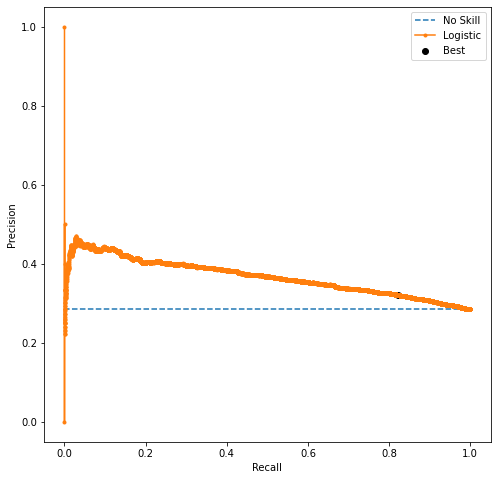

In [32]:
#-------------------------------- Precision / Recall ---------------------------------#
from sklearn.metrics import precision_recall_curve
from numpy import nanargmax

y_score_lr = LogReg.decision_function(X_test_sc)
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_test_1, y_score_lr)

# convert to f score
fscore_lr = (2 * precision_lr * recall_lr) / (precision_lr + recall_lr)

# locate the index of the largest f score
ix = nanargmax(fscore_lr)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds_lr[ix], fscore_lr[ix]))
print('Recall=%.3f, Precision=%.3f' % (recall_lr[ix], precision_lr[ix]))

# plot the roc curve for the model
no_skill = len(y_test_1[y_test_1==1]) / len(y_test_1)

fig = plt.figure(figsize=(8,8))
fig = plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
fig = plt.plot(recall_lr, precision_lr, marker='.', label='Logistic')
fig = plt.scatter(recall_lr[ix], precision_lr[ix], marker='o', color='black', label='Best')
# axis labels
fig = plt.xlabel('Recall')
fig = plt.ylabel('Precision')
fig = plt.legend()
# show the plot
plt.show()


### <font color = Navy> Reports before Threshold amendments 

              precision    recall  f1-score   support

          No       0.72      0.97      0.83     10371
         Yes       0.45      0.06      0.10      4149

    accuracy                           0.71     14520
   macro avg       0.58      0.51      0.47     14520
weighted avg       0.64      0.71      0.62     14520



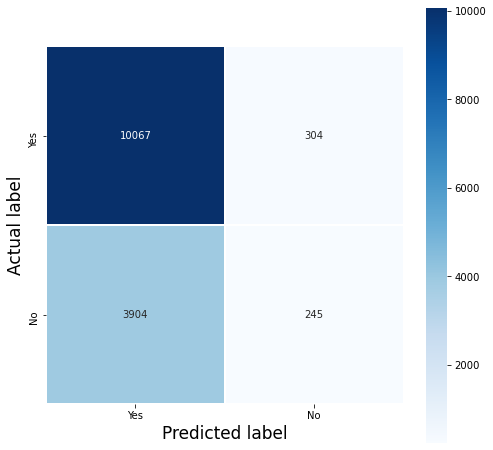

In [33]:
#-------------------------------- Classification Report ---------------------------------#
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))


#-------------------------------- Confusion Matrix ---------------------------------#
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, preds)

# plot it!
fig = plt.figure(figsize=(8,8))
ax = sns.heatmap(cm, annot=True,
            fmt=".0f",
            linewidths=.5,
            square = True,
            cmap = 'Blues', xticklabels = ["Yes", "No"], yticklabels = ["Yes", "No"]);
ax.set_ylabel('Actual label', fontsize = 17);
ax.set_xlabel('Predicted label', fontsize = 17);
#ax.set_title('Accuracy Score: {}'.format(score), size = 17);
#plt.tick_params(labelsize= 15)

### <font color = Navy> Reports After Threshold amendments 

In [34]:
#Set new threshold
best_threshold = thresholds_lr[ix]

# get the probability score for every X test
y_score_lr = LogReg.decision_function(X_test_sc)
    
# get the prediction based on threshold value
y_thres = np.vectorize(lambda y: 'Yes' if y >= best_threshold else 'No')(y_score_lr)

              precision    recall  f1-score   support

          No       0.81      0.31      0.45     10371
         Yes       0.32      0.82      0.46      4149

    accuracy                           0.45     14520
   macro avg       0.57      0.57      0.45     14520
weighted avg       0.67      0.45      0.45     14520



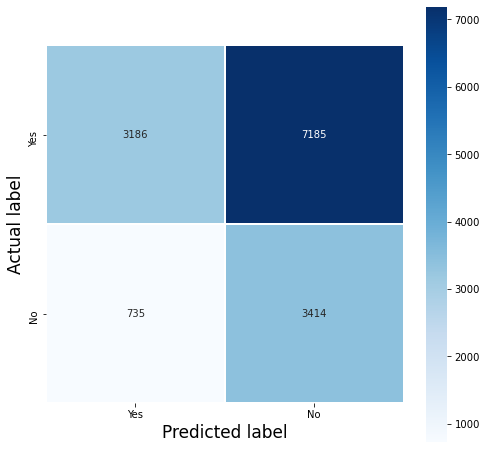

In [35]:
#-------------------------------- Classification Report ---------------------------------#
from sklearn.metrics import classification_report
print(classification_report(y_test, y_thres))


#-------------------------------- Confusion Matrix ---------------------------------#
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_thres)

# plot it!
fig = plt.figure(figsize=(8,8))
ax = sns.heatmap(cm, annot=True,
            fmt=".0f",
            linewidths=.5,
            square = True,
            cmap = 'Blues', xticklabels = ["Yes", "No"], yticklabels = ["Yes", "No"]);
ax.set_ylabel('Actual label', fontsize = 17);
ax.set_xlabel('Predicted label', fontsize = 17);
#ax.set_title('Accuracy Score: {}'.format(score), size = 17);
#plt.tick_params(labelsize= 15)

### <font color = Navy> Amending Threshold to give the best F1 Score increases Recall (from 0.06 to 0.82) however notably precision and accuracy suffers as a result. Nevertheless, churn is a recall-oriented machine learning task. False negatives hurt performance more than false positives so we will go with the model with higher recall. 

### 4.2 Build Random Forest classifier to compare model accuracy over the logistic regression model


In [51]:
#-------------------------------- Model training -------------------------------#

#type your code to build random forest classifier model on training data set

from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(random_state=0)
classifier.fit(X_train, y_train)


RandomForestClassifier(random_state=0)

In [52]:
#-------------------------------- Model testing ---------------------------------#

#type your code here to predict for X_test data set using the fitted RF model
y_pred_rf = classifier.predict(X_test)

#Use a probability threshold to classify customers as churners and non churners (Default = 0.5)
score_rf = classifier.score(X_test, y_test)

Best Threshold=0.300000, G-Mean=0.602


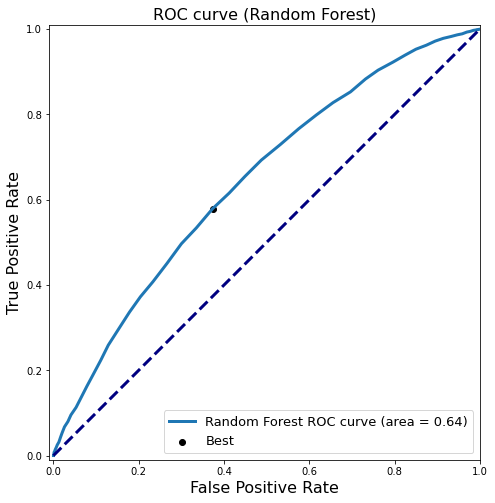

Gini Score is: 0.2868298350990264


In [53]:
#-------------------------------- Model Evaluation ---------------------------------#
#Evaluate model accuracy using fitted y value and actual y_test
#Evaluation metrics to be used - GINI, Precision, Recall, confusion matrix


#-------------------------------- AUC ---------------------------------#
from sklearn.metrics import roc_curve, auc
#Change y_test to 1 and 0
y_test_1 = y_test.replace([ "Yes",  "No"],  [1,0])

#GET AUC
y_score_rf = classifier.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, threshold_rf = roc_curve(y_test_1, y_score_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)


#-------------------------------- Get the best threshold ---------------------------------#
#calculate the g-mean for each threshold
from numpy import sqrt
from numpy import argmax
gmeans = sqrt(tpr_rf*(1-fpr_rf))

#locate the index of the largest g-mean
ix = argmax(gmeans)
print("Best Threshold=%f, G-Mean=%.3f" % (threshold_rf[ix],gmeans[ix]))

#-------------------------------- Plot AUC ---------------------------------#

fig = plt.figure(figsize=(8,8))
fig = plt.xlim([-0.01, 1.00])
fig = plt.ylim([-0.01, 1.01])
fig = plt.plot(fpr_rf, tpr_rf, lw=3, label='Random Forest ROC curve (area = {:0.2f})'.format(roc_auc_rf))
fig = plt.scatter(fpr_rf[ix],tpr_rf[ix], marker = 'o', color = 'black', label = 'Best')
fig = plt.xlabel('False Positive Rate', fontsize=16)
fig = plt.ylabel('True Positive Rate', fontsize=16)
fig = plt.title('ROC curve (Random Forest)', fontsize=16)
fig = plt.legend(loc='lower right', fontsize=13)
fig = plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
fig = plt.axes().set_aspect('equal')
plt.show()

print("Gini Score is:", 2*roc_auc_rf - 1)


Best Threshold=0.250000, F-Score=0.478
Recall=0.767, Precision=0.348


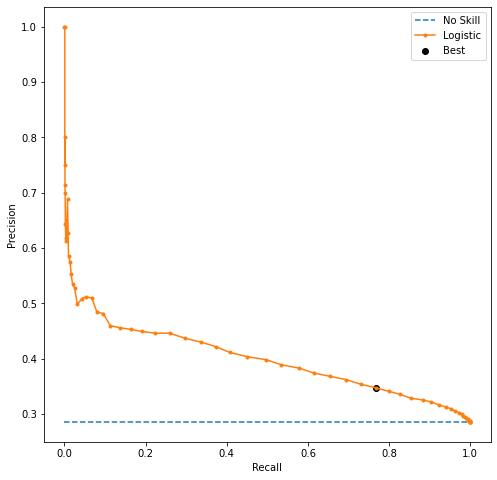

In [54]:
#-------------------------------- Precision / Recall ---------------------------------#
from sklearn.metrics import precision_recall_curve
from numpy import nanargmax

y_score_rf = classifier.predict_proba(X_test)[:, 1]
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test_1, y_score_rf)

# convert to f score
fscore_rf = (2 * precision_rf * recall_rf) / (precision_rf + recall_rf)

# locate the index of the largest f score
ix = nanargmax(fscore_rf)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds_rf[ix], fscore_rf[ix]))
print('Recall=%.3f, Precision=%.3f' % (recall_rf[ix], precision_rf[ix]))

# plot the roc curve for the model
no_skill = len(y_test_1[y_test_1==1]) / len(y_test_1)

fig = plt.figure(figsize=(8,8))
fig = plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
fig = plt.plot(recall_rf, precision_rf, marker='.', label='Logistic')
fig = plt.scatter(recall_rf[ix], precision_rf[ix], marker='o', color='black', label='Best')
# axis labels
fig = plt.xlabel('Recall')
fig = plt.ylabel('Precision')
fig = plt.legend()
# show the plot
plt.show()


### <font color = Navy> Reports before Threshold amendments 

              precision    recall  f1-score   support

          No       0.72      0.99      0.83     10371
         Yes       0.54      0.02      0.04      4149

    accuracy                           0.72     14520
   macro avg       0.63      0.51      0.44     14520
weighted avg       0.67      0.72      0.61     14520



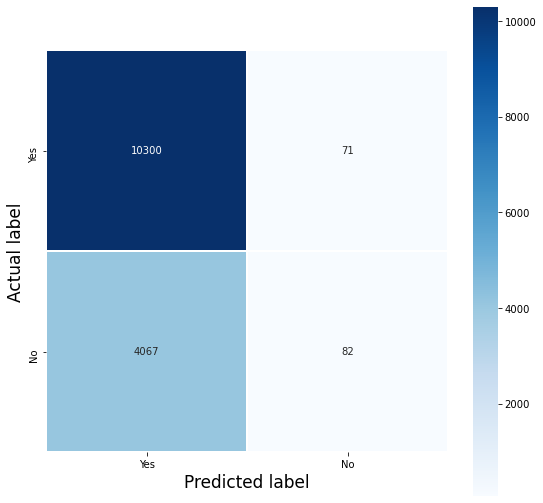

In [55]:
#-------------------------------- Model Evaluation ---------------------------------#

#Evaluate model accuracy using fitted y value and actual y_test
#Evaluatio metrics to be used - GINI, Precision, Recall, confusion matrix


#-------------------------------- Classification Report ---------------------------------#
print(classification_report(y_test, y_pred_rf))

#-------------------------------- Confusion Matrix ---------------------------------#
cm = confusion_matrix(y_test, y_pred_rf)

# plot it!
fig2 = plt.figure(figsize=(9,9))
ax2 = sns.heatmap(cm, annot=True,
            fmt=".0f",
            linewidths=.5,
            square = True,
            cmap = 'Blues', xticklabels = ["Yes", "No"], yticklabels = ["Yes", "No"]);
ax2.set_ylabel('Actual label', fontsize = 17);
ax2.set_xlabel('Predicted label', fontsize = 17);
#ax2.set_title('Accuracy Score: {}'.format(score_rf), size = 17);
#plt.tick_params(labelsize= 15)

### <font color = Navy> Reports After Threshold amendments 

In [56]:
#Set new threshold
best_threshold = thresholds_rf[ix]

# get the probability score for every X test
y_score_rf = classifier.predict_proba(X_test)[:, 1]
    
# get the prediction based on threshold value
y_thres = np.vectorize(lambda y: 'Yes' if y >= best_threshold else 'No')(y_score_rf)

              precision    recall  f1-score   support

          No       0.82      0.42      0.56     10371
         Yes       0.35      0.77      0.48      4149

    accuracy                           0.52     14520
   macro avg       0.58      0.60      0.52     14520
weighted avg       0.68      0.52      0.54     14520



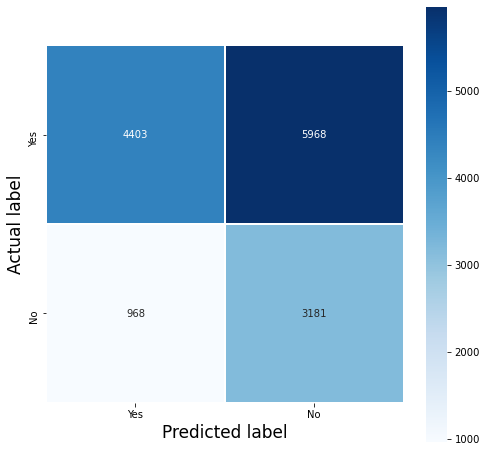

In [57]:
#-------------------------------- Classification Report ---------------------------------#
from sklearn.metrics import classification_report
print(classification_report(y_test, y_thres))


#-------------------------------- Confusion Matrix ---------------------------------#
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_thres)

# plot it!
fig = plt.figure(figsize=(8,8))
ax = sns.heatmap(cm, annot=True,
            fmt=".0f",
            linewidths=.5,
            square = True,
            cmap = 'Blues', xticklabels = ["Yes", "No"], yticklabels = ["Yes", "No"]);
ax.set_ylabel('Actual label', fontsize = 17);
ax.set_xlabel('Predicted label', fontsize = 17);
#ax.set_title('Accuracy Score: {}'.format(score), size = 17);
#plt.tick_params(labelsize= 15)

### <font color = navy> Findings
    
- Random forest gives a slightly better F1 score though recall is a bit lower than logistic regression. 

### 4.3 Identify most important features impacting churn

CurrentEquipmentDays     0.040906
PercChangeMinutes        0.034267
perc_recurrent_charge    0.032298
MonthsInService          0.032046
MonthlyMinutes           0.031115
MonthlyRevenue           0.029904
PercChangeRevenues       0.029720
OffPeakCallsInOut        0.027942
PeakCallsInOut           0.027263
ReceivedCalls            0.027162
UnansweredCalls          0.026870
OutboundCalls            0.025923
DroppedBlockedCalls      0.024862
DroppedCalls             0.023880
TotalRecurringCharge     0.023038
InboundCalls             0.021581
BlockedCalls             0.021122
perc_overage_minutes     0.021010
AgeHH1                   0.020666
OverageMinutes           0.019524
dtype: float64


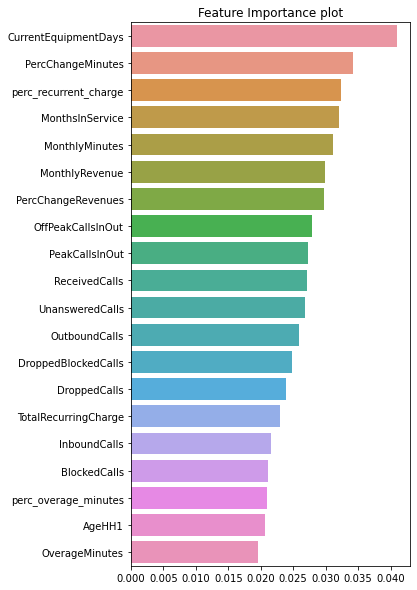

In [59]:
# Type your code here to plot the top 20 important predictor features impacting churn using the Random Forest model created

features_sorted = pd.Series(classifier.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(features_sorted.head(20))

_ = plt.figure(figsize=(5,10))
_ = plt.title("Feature Importance plot")
#_ = features_sorted.nlargest(20).sort_values(ascending=True).plot(kind='barh',)

_ = sns.barplot(y = features_sorted.nlargest(20).index, x = features_sorted.nlargest(20).values)


## Lift chart and total monthly revenue saved by targeting top 10-20% of the customers using best predictive model

In [ ]:
#!pip install scikit-plot

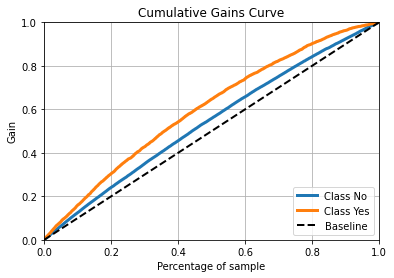

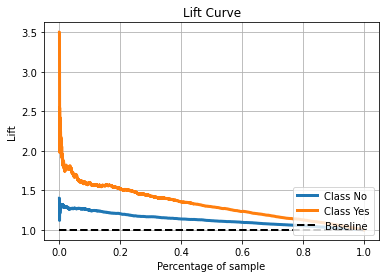

In [84]:
#Type your code here to plot the lift chart from the best model
#Identify the lift i.e. 3x of capturing churn with and without using the model 
#(Assume: only top 20% high risk customers are to be targeted)


import scikitplot as skplt

# Deriving Class probabilities
predicted_probabilities = classifier.predict_proba(X_test)

# a_probabilities = np.zeros(shape=predicted_probabilities.shape)
# i = 0
# for item in y_thres:
#     if (item == 'Yes'):
#         a_probabilities[i] = [0,1]
#     else:
#         a_probabilities[i] = [1,0]
    
#     i += 1    

# Scikitplot cumulative gains curve
_ = skplt.metrics.plot_cumulative_gain(y_test, predicted_probabilities)

#Scikitplot lift curve
_ = skplt.metrics.plot_lift_curve(y_test, predicted_probabilities)


In [96]:
# determine number of samples in top 20%
n = int(0.2*y_test.shape[0])
print("Number of samples in top 20%:", n)

# determine the Churn Class Order used in Tree
#classifier.classes_

# create initial data frame where monthly revenue column is merged with y_test column
top_20_percent_customers = pd.merge(left=X_test['MonthlyRevenue'], left_index=True,
                  right=y_test, right_index=True,
                  how='inner')

# Monthly Revenue of top 20% of test data sorted by their Churn prediction probabilities
top_20_percent_customers['pred_prob_churn'] = predicted_probabilities[:,1]
top_20_percent_customers_rev = top_20_percent_customers.sort_values(by=['pred_prob_churn'], ascending=False).head(n)

# Monthly Revenue of top 20% of test data sorted by their Churn prediction probabilities 
# and filtered by actual Churn customers
top_20_percent_customers_rev = top_20_percent_customers_rev.loc[top_20_percent_customers_rev['Churn'] == 'Yes']

# Sum up Monthly Revenue of top 20% of test data sorted by their Churn prediction probabilities 
# and filtered by actual Churn customers
print('{:.2f}% of churners are in the top 20%'.format(100*len(top_20_percent_customers_rev)/y_test.value_counts()[1]))
print('total monthly revenue of actual churn customers identified in the top 20% of the customers is $ {:.2f}'.format(top_20_percent_customers_rev['MonthlyRevenue'].sum()))

Number of samples in top 20%: 2904
30.44% of churners are in the top 20%
total monthly revenue of actual churn customers identified in the top 20% of the customers is $ 73881.06


### <font color = navy> Findings
    
- Just by targeting the top 20%, we can identify 30% of churners and save $73,881.06